In [1]:
        import numpy as np # numpy

from sklearn import datasets # load dataset
from sklearn.model_selection import train_test_split # split dataset
from sklearn.preprocessing import StandardScaler # standard scaler
from sklearn.svm import SVC # import model
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score # check accuracy
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn import preprocessing

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_graph(list_of_x, list_of_y, labelX, labelY):
    plt.plot(list_of_x, list_of_y, color="red", marker="o",  linestyle="")
    ax = plt.gca()
    ax.tick_params(axis='y', colors='red')
    ax.tick_params(axis='x', colors='red')
    
    ax.set_xlabel(labelX)
    ax.xaxis.label.set_color('red')

    ax.set_ylabel(labelY)
    ax.yaxis.label.set_color('red')
    
    plt.xticks(np.arange(min(list_of_x) * (-1), max(list_of_x), 1))
    plt.yticks(np.arange(0, 1, 0.1))
    plt.show()
    

def replicate_classes(X, y):

    X_class_minoritary = X[y==1] #pd.DataFrame(data= np.c_[iris['data'], iris['target']],columns= iris['feature_names'] + ['target'])
    y_class_minoritary = y[y==1]
    
    conX = np.concatenate((X, X_class_minoritary), axis=0)
    
    conY = np.concatenate((y, y_class_minoritary), axis=0)
    
    return conX, conY

In [2]:
def get_sigmaE(vectorX, vectorW):
    """
        Multiplies the input (vectorX) by the weights (vectorW), resulting in a diagonal matrix. 
        It discards any imaginary part vectorX and vectorW might have.
        Equivalent of Equation #17 in the Article.
    """
    n = len(vectorX)
    sigmaE = np.zeros((n,n))
    for i in range(n):
        sigmaE[i,i] = np.real(vectorX[i])*np.real(vectorW[i])

    return sigmaE

def get_sigmaQ(n):
    """
        Sums sigmaX, sigmaY and sigmaZ to get sigmaQ.
        - sigmaX comes from Equation #7 = [0, 1   1, 0]
        - sigmaY comes from Equation #8 = [0, -i  i, 0]
        - sigmaZ comes from Equation #9 = [1, 0   0, -1]
        Equivalent of Equation #16 in the Article.
    """
    sigmaQ = np.zeros((n,n))
    sigmaX = np.array([[0,1], [1,0]])
    sigmaY = np.array([[0,-1j], [1j,0]])
    sigmaZ = np.array([[1,0], [0,-1]])
    sigmaQ = sigmaX + sigmaY + sigmaZ

    return sigmaQ

def get_sigmaQ_param(n, param):
    """
        Sums sigmaX, sigmaY and sigmaZ to get sigmaQ.
        - sigmaX comes from Equation #7 = [0, 1   1, 0]
        - sigmaY comes from Equation #8 = [0, -i  i, 0]
        - sigmaZ comes from Equation #9 = [1, 0   0, -1]
        Equivalent of Equation #16 in the Article.
    """
    sigmaQ = np.zeros((n,n))
    sigmaX = np.array([[0,1], [1,0]])
    sigmaY = np.array([[0,-1j], [1j,0]])
    sigmaZ = np.array([[1,0], [0,-1]])
    sigmaH = np.array([[1,1],[1,-1]])*(1/np.sqrt(2))
    sigmaQ = param[0]*sigmaX + param[1]*sigmaY + param[2]*sigmaZ + param[3]*sigmaH

    return sigmaQ


def get_U_operator(sigmaQ, sigmaE):
    """
        Makes the exponential matrix of tensor product between sigmaQ and sigmaE and multiplies it by j. 
        Equivalent of Equation #15 in the Article.
    """
    sigmaQ[np.isnan(sigmaQ)] = 0
    sigmaE[np.isnan(sigmaE)] = 0
    return np.matrix(expMatrix(1j*np.kron(sigmaQ, sigmaE)))

def get_p(psi):
    """
        Creates a matrix out of psi and multiply it against its inverse, 
        resulting in a column vector in the form [[alfa]. [beta]].
        Does the operation |psi><psi| from Equation #18 or #19 in the Article.
    """
    psi = np.matrix(psi)
    return psi * psi.getH()



def create_and_execute_classifier_ORIGINAL(vectorX, vectorW, normalizeX=False, normalizeW=False, paramsClassifier=[1,1,1,0]):
    """
        Applies the ICQ classifier using only the math behind the Quantum Classifier 
        described in Interactive Quantum Classifier Inspired by Quantum Open System Theory
        article. 
        After doing so, it gets the result of Equation #20 and returns Z as the predicted class and
        the probability of being the class 1.
        Works only for binary classifications, therefore, if the probability of class 0 is needed, it can
        be 1 - probability of being class 1.
    """
    params = paramsClassifier

    if normalizeX:
        vectorX = normalize(vectorX)
    if normalizeW:
        vectorW = normalize(vectorW)

    # Eq #16
    #sigmaQ = get_sigmaQ(2)
    sigmaQ = get_sigmaQ_param(2, params)

    # Eq #17
    sigmaE = get_sigmaE(vectorX, vectorW)

    # Eq #15
    U_operator = get_U_operator(sigmaQ, sigmaE)

    # Eq #18 applied on a Quantum state equivalent of Hadamard(|0>) = 1/sqrt(2) * (|0> + |1>) 
    p_cog = get_p([[1/np.sqrt(2)],[1/np.sqrt(2)]])

    # As we must have 1 row per attribute of the input, we need env to be as big as one instance of our input
    N = len(vectorX)

    # Eq #19 applied on a Quantum state equivalent of Hadamard(|000000...>) = 1/sqrt(N) * (|000000...> + ... + |11111111....>) 
    p_env = get_p([[1/np.sqrt(N)] for i in range(N)])

    # First part of Equation #20 in the Article
    quantum_operation = np.array(U_operator * (np.kron(p_cog, p_env)) * U_operator.getH())

    # Second part of Equation #20 in the Article
    p_cog_new = np.trace(quantum_operation.reshape([2,N,2,N]), axis1=1, axis2=3)

    # As the result is a diagonal matrix, the probability of being class 0 will be on position 0,0
    p_cog_new_00_2 = p_cog_new[0,0]

    # ... and the probability of being class 1 will be on position 1,1
    p_cog_new_11_2 = p_cog_new[1,1]
    if (p_cog_new_00_2 >= p_cog_new_11_2):
        z = 0
    else:
        z = 1
    return z, p_cog_new_11_2, U_operator

def create_and_execute_classifier_NEW(vectorX, vectorW, normalizeX=False, normalizeW=False):
    """
        Applies the ICQ classifier using only the math behind the Quantum Classifier 
        described in Interactive Quantum Classifier Inspired by Quantum Open System Theory
        article. 
        After doing so, it gets the result of Equation #20 and returns Z as the predicted class and
        the probability of being the class 1.
        Works only for binary classifications, therefore, if the probability of class 0 is needed, it can
        be 1 - probability of being class 1.
    """

    global params
    if normalizeX:
        vectorX = normalize(vectorX)
    if normalizeW:
        vectorW = normalize(vectorW)  
    # Eq #16
    #sigmaQ = get_sigmaQ(2)
    #alfa, beta, delta, gama = params # [Symbol(chr(ord('X') + i)) for i in range(1,5)]
    #sigmaQ = np.matrix([
    #     [exp(1j*(alfa-beta/2-delta/2))*cos(gama/2), exp(1j*(alfa-beta/2+delta/2))*sin(gama/2)],
    #    [exp(1j*(alfa+beta/2-delta/2))*sin(gama/2), exp(1j*(alfa+beta/2+delta/2))*cos(gama/2)]
    #    ])
    #theta, phi, delta = params # [Symbol(chr(ord('X') + i)) for i in range(1,5)]
    #sigmaQ = np.matrix([
    #     [cos(theta/2), -exp(1j*delta)*sin(theta/2)],
    #     [exp(1j*phi)*sin(theta/2), exp(1j*(phi+delta))*cos(theta/2)]
    #    ])
    sigmaQ = get_sigmaQ_param(2, params)

    #alfa, beta, gama, delta = params
    #sigmaE = np.matrix([
    #     [exp(1j*(alfa-beta/2-delta/2))*cos(gama/2), exp(1j*(alfa-beta/2+delta/2))*sin(gama/2)],
    #     [exp(1j*(alfa+beta/2-delta/2))*sin(gama/2), exp(1j*(alfa+beta/2+delta/2))*cos(gama/2)]
    #    ])

    # Eq #17
    #sigmaE = get_sigmaE(vectorX, vectorW)

    N = len(vectorX)
    # Eq #15
    sigmaE = np.zeros((N,N))
    for i in range(N):
        sigmaE[i,i] = vectorW[i]
        
    U_operator = get_U_operator(sigmaQ, sigmaE)

    # Eq #18 applied on a Quantum state equivalent of Hadamard(|0>) = 1/sqrt(2) * (|0> + |1>) 
    p_cog = get_p([[1/np.sqrt(2)],[1/np.sqrt(2)]])

    # As we must have 1 row per attribute of the input, we need env to be as big as one instance of our input
    

    # Eq #19 applied on a Quantum state equivalent of Hadamard(|000000...>) = 1/sqrt(N) * (|000000...> + ... + |11111111....>) 
    vectorX = normalize(vectorX)
    p_env = get_p([[vectorX_i] for vectorX_i in vectorX])

    # First part of Equation #20 in the Article
    quantum_operation = np.array(U_operator * (np.kron(p_cog, p_env)) * U_operator.getH())

    # Second part of Equation #20 in the Article
    p_cog_new = np.trace(quantum_operation.reshape([2,N,2,N]), axis1=1, axis2=3)

    # As the result is a diagonal matrix, the probability of being class 0 will be on position 0,0
    p_cog_new_00_2 = p_cog_new[0,0]

    # ... and the probability of being class 1 will be on position 1,1
    p_cog_new_11_2 = p_cog_new[1,1]
    if (p_cog_new_00_2 >= p_cog_new_11_2):
        z = 0
    else:
        z = 1
    return z, p_cog_new_11_2, U_operator

def update_weights(weights, y, z, x, p, n):
  """
    Updates the weights. Equation #34 in the Article.

    y is the expected classification [0, 1];
    z is the actual classification [0, 1];
    x is the attribute vector;
    p is the probability of the class 1 (0, 1), powered to 2 (p²);
    n is the learning rate.
  """
  # Eq 33
  loss_derivative_on_weight = (1-p)*x

  # Eq 34
  weights = weights-n*(z-y)*loss_derivative_on_weight
  weights[np.isnan(weights)] = 0
  return weights


def get_prob_1(hist):
    count0 = 0
    count1 = 0
    if '0' in hist:
        count0 = hist['0']
    if '1' in hist:
        count1 = hist['1']
    return count1/(count1+count0)

def normalize(x):
    v_norm = x / (np.linalg.norm(x) + 1e-16)
    return v_norm

def update_weights(weights, y, z, x, p, n):
  """
    Updates the weights. Equation #34 in the Article.
    
    y is the expected classification [0, 1];
    z is the actual classification [0, 1];
    x is the attribute vector;
    p is the probability of the class 1 (0, 1), powered to 2 (p²);
    n is the learning rate.
  """
  # Eq 33
  loss_derivative_on_weight = (1-p)*x

  # Eq 34
  weights = weights-n*(z-y)*loss_derivative_on_weight
  weights[np.isnan(weights)] = 0
  return weights

In [4]:
import numpy as np
from scipy.linalg import expm as expMatrix

import numpy as np
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from sklearn.metrics import f1_score


class TemplateClassifier(ClassifierMixin, BaseEstimator):
    """ An example classifier which implements a 1-NN algorithm.
    For more information regarding how to build your own classifier, read more
    in the :ref:`User Guide <user_guide>`.
    Parameters
    ----------
    demo_param : str, default='demo'
        A parameter used for demonstation of how to pass and store paramters.
    Attributes
    ----------
    X_ : ndarray, shape (n_samples, n_features)
        The input passed during :meth:`fit`.
    y_ : ndarray, shape (n_samples,)
        The labels passed during :meth:`fit`.
    classes_ : ndarray, shape (n_classes,)
        The classes seen at :meth:`fit`.
    """
    def __init__(self, classifierFunction, rate_succ=0.2, paramsClassifier=None, MAX_ITER=1000, demo_param='demo'):
        self.demo_param = demo_param
        self.rate_succ = rate_succ
        self.classifierFunction = classifierFunction
        self.MAX_ITER = MAX_ITER
        self.paramsClassifier = paramsClassifier

    def fit(self, X, y):
        """A reference implementation of a fitting function for a classifier.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,)
            The target values. An array of int.
        Returns
        -------
        self : object
            Returns self.
        """
        np.random.seed(1)
        
        X,y = replicate_classes(X, y)
            
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        low  = -1
        high = 1
        dimensions = len(X[0])

        rate=0
        
        weight = np.random.uniform(low=low, high=high, size=(dimensions,))
        
        ITERATION = 0
        
        bestWeight = []
        bestRate = 0.0
        self.ratesDuringTraining = []
        
        
        while rate < self.rate_succ and ITERATION < self.MAX_ITER:
            rate=0
            #training step
            for x_train, y_train in zip(X, y):
                z, p_cog, qo = self.classifierFunction(x_train, weight, self.paramsClassifier)
                weight = update_weights(weight, y_train, z, x_train, p_cog, n=0.01)
                
            for x_train, y_train in zip(X, y):
                z, p_cog, qo = self.classifierFunction(x_train, weight, self.paramsClassifier)            
                if z == y_train:
                    rate +=1
            
            rate = rate/len(X)
            self.ratesDuringTraining.append(rate)
            ITERATION += 1
            if (rate >= bestRate):
                bestWeight = weight
                bestRate = rate
            if ITERATION%1000 == 0:
                weight = np.random.uniform(low=low, high=high, size=(dimensions,))
            
        self.rate = bestRate
        self.weight_ = bestWeight
        self.X_ = X
        self.y_ = y
        print("best weight", bestWeight)
        print("best rate", bestRate)
        plot_graph(range(ITERATION), self.ratesDuringTraining , "iter", "rate")
        # Return the classifier
        return self

    def predict(self, X):
        """ A reference implementation of a prediction for a classifier.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            The label for each sample is the label of the closest sample
            seen during fit.
        """
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_', 'weight_'])

        # Input validation
        X = check_array(X)
        
        outputs = []
        for x in X:                   
            z, p_cog, qo = self.classifierFunction(x, self.weight_, self.paramsClassifier)
            outputs.append(z)
                               
        return outputs

    def predict_proba(self, X):
        outputs = []
        for x in X:                   
            z, p_cog, qo = self.classifierFunction(x, self.weight_, self.paramsClassifier)
            outputs.append([1-p_cog.real, p_cog.real])
                               
        return np.array(outputs)

def executeIris(randomState = 1, classifierFunction=None, paramsClassifier=[1,1,1,0], MAX_ITER=3000):
    # load dataset
    iris = datasets.load_iris()
    X = iris.data[:, [0,1,2, 3]]
    y = iris.target

    # split training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = randomState, stratify = y)


    # apply MinMaxScaler for iris data set, [0, 1] for the range
    from sklearn.preprocessing import MinMaxScaler
    normalized_X_train = preprocessing.normalize(X_train)
    normalized_X_test  = preprocessing.normalize(X_test)
    
    clf = OneVsRestClassifier(
        TemplateClassifier(
            classifierFunction=classifierFunction, 
            paramsClassifier = paramsClassifier,
            MAX_ITER=MAX_ITER,
            rate_succ=1.0)).fit(normalized_X_train, y_train)

    score = clf.score(normalized_X_test, y_test)
    f1score = f1_score(clf.predict(normalized_X_test), y_test, average='macro')

    return score, f1score

best weight [-0.72366212-7.55659211e-19j  0.18137508-3.77011548e-19j
 -1.40761516-5.83762176e-19j -0.53508083-2.15288828e-19j]
best rate 1.0


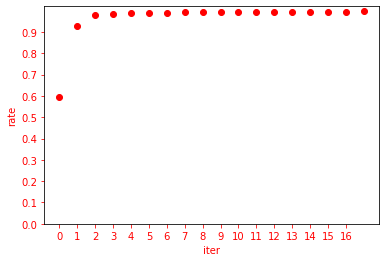

best weight [-1.12837129+8.96018258e-18j -1.20337016-1.27909913e-18j
 -1.1453784 +7.98374339e-18j -2.01183291-5.41816241e-18j]
best rate 0.95


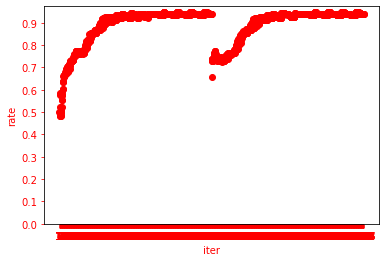

best weight [-1.26194794-4.01847534e-17j -1.32605745-1.98164779e-17j
 -0.77012978-2.91963083e-17j -0.52336799-8.77417937e-18j]
best rate 0.9888888888888889


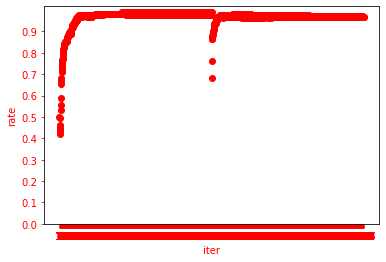

best weight [-0.68523619-5.26434513e-19j  0.20182761-2.07033603e-19j
 -1.38662951-5.06511426e-19j -0.52662784-1.78521975e-19j]
best rate 1.0


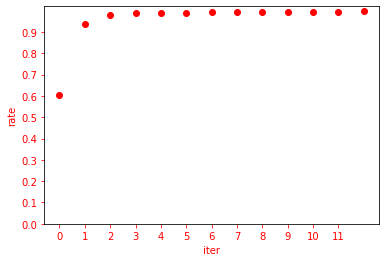

best weight [-1.1176546 -3.55522861e-17j -1.21305919-2.26573279e-17j
 -1.16059081-2.90883313e-17j -1.98948103-1.97249238e-17j]
best rate 0.9388888888888889


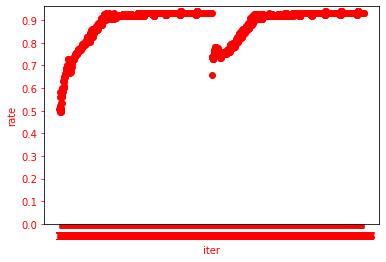

best weight [-1.30924579-1.04907165e-16j -1.35788987-4.91126786e-17j
 -0.69423286-8.03591650e-17j -0.67669787-2.63068802e-17j]
best rate 0.9833333333333333


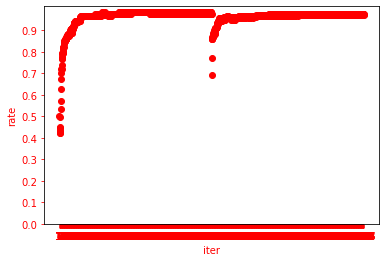

best weight [-0.72294269-1.15166101e-18j  0.18101442-5.40287234e-19j
 -1.40708402-9.03818605e-19j -0.53587102-3.24732029e-19j]
best rate 1.0


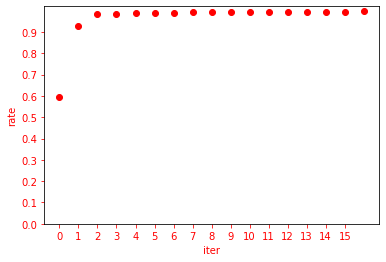

best weight [-1.13374489-2.93467818e-17j -1.2110605 -1.82376824e-17j
 -1.13885547-2.39664248e-17j -2.02182877-1.73131550e-17j]
best rate 0.9666666666666667


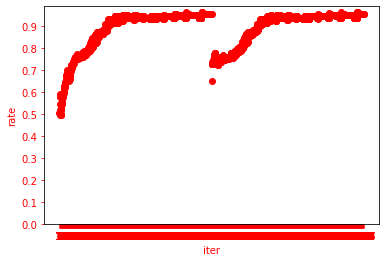

best weight [-1.26563523-2.32619561e-17j -1.38245815-1.37089697e-17j
 -0.72864878-1.54914484e-17j -0.53676672-5.85274659e-18j]
best rate 0.9888888888888889


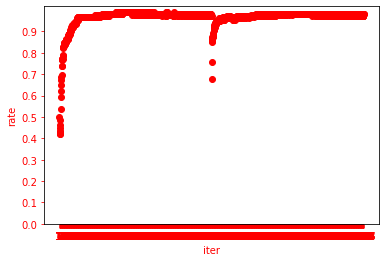

best weight [-0.72428628-8.72504172e-19j  0.18255247-4.10053612e-19j
 -1.40659922-7.59743415e-19j -0.53457553-2.43662329e-19j]
best rate 1.0


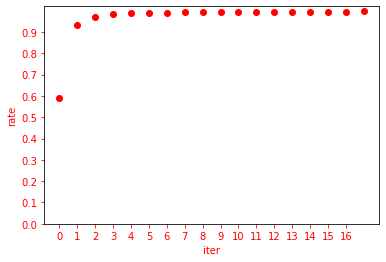

best weight [-1.048873  -3.30043695e-17j -1.20848592-2.22939790e-17j
 -1.25116355-3.02445713e-17j -2.00175156-1.84281676e-17j]
best rate 0.9666666666666667


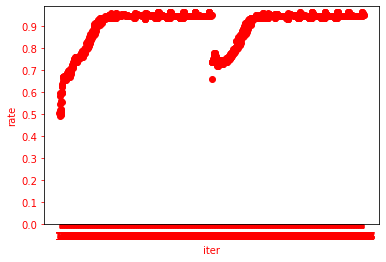

best weight [-1.29976727-2.55994930e-17j -1.36005037-1.45682440e-17j
 -0.63313182-1.77259549e-17j -0.53078766-7.81675622e-18j]
best rate 0.9888888888888889


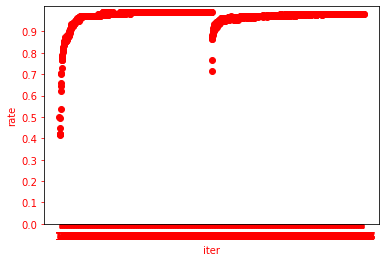

best weight [-0.7204559 -6.12004513e-19j  0.18525549-2.93357471e-19j
 -1.40655007-4.88517275e-19j -0.53412155-1.60782440e-19j]
best rate 1.0


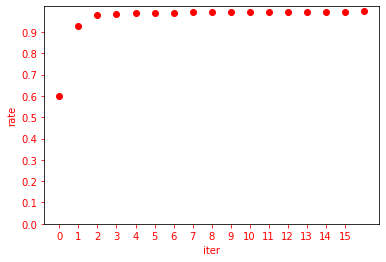

best weight [-1.08728999-6.01891701e-17j -1.22002356-3.20330211e-17j
 -1.2038634 -4.93578998e-17j -1.94543588-2.78004305e-17j]
best rate 0.95


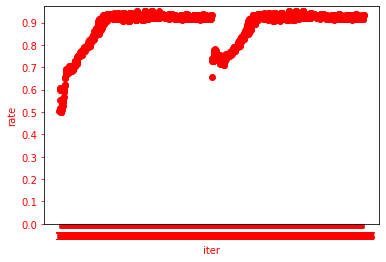

best weight [-1.28533526-5.90347265e-17j -1.37626392-2.61207803e-17j
 -0.71743367-4.28694796e-17j -0.60888084-1.31858367e-17j]
best rate 0.9888888888888889


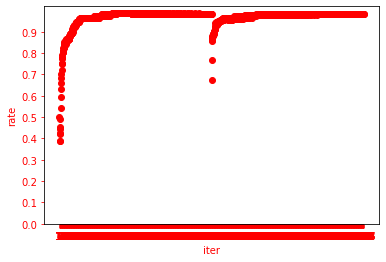

best weight [-0.72445938-4.55007097e-19j  0.18145005-1.67100282e-19j
 -1.4061712 -4.60199548e-19j -0.53324201-1.50243228e-19j]
best rate 1.0


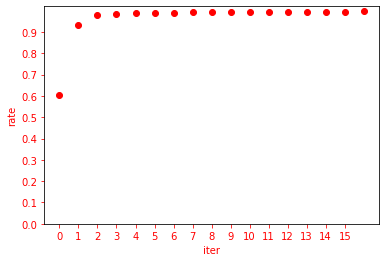

best weight [-1.11356415+7.88706468e-18j -1.23300392+8.03548826e-19j
 -1.16433657+9.09754401e-18j -1.96788527-3.06407891e-18j]
best rate 0.9444444444444444


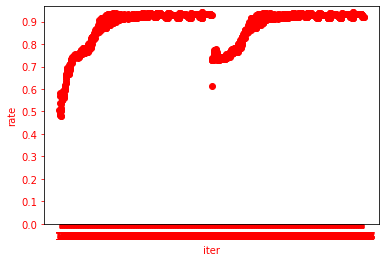

best weight [-1.26535979-3.18066835e-17j -1.38065205-1.64912557e-17j
 -0.73027203-2.29064826e-17j -0.53656956-7.65978481e-18j]
best rate 0.9833333333333333


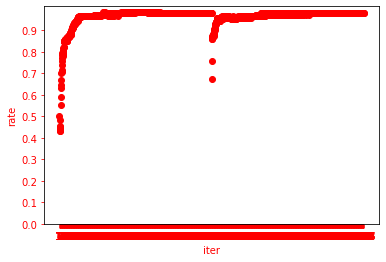

best weight [-0.72504081-7.20925073e-19j  0.18112671-3.29999240e-19j
 -1.40547768-5.67760064e-19j -0.53180563-2.05903110e-19j]
best rate 1.0


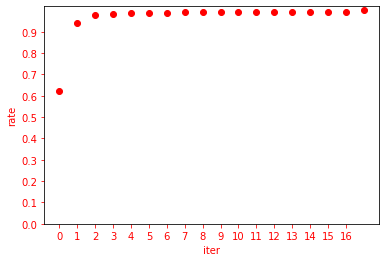

best weight [-1.11238735-3.82113703e-17j -1.21123366-1.99673461e-17j
 -1.17318905-2.86183045e-17j -1.98156899-1.80038961e-17j]
best rate 0.9666666666666667


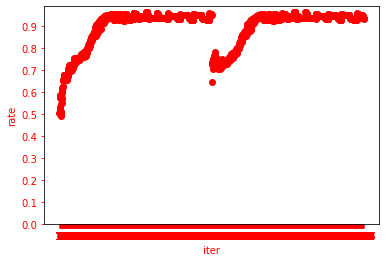

best weight [-1.2640761 -5.78325136e-17j -1.38652792-2.87324033e-17j
 -0.74333075-4.34803010e-17j -0.58575879-1.35400986e-17j]
best rate 0.9833333333333333


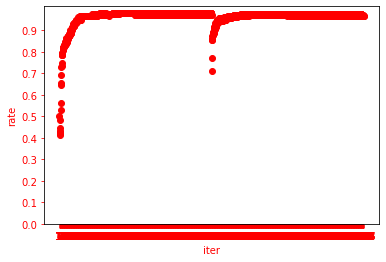

best weight [-0.72328154-3.45262489e-19j  0.18025384-1.41223616e-19j
 -1.40812117-3.15108909e-19j -0.53474168-1.15841125e-19j]
best rate 1.0


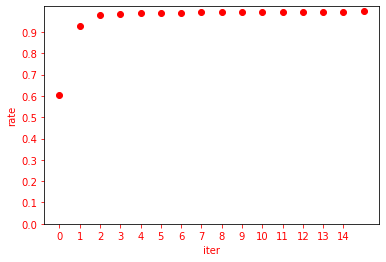

best weight [-1.09053735+7.41654146e-19j -1.23354368-6.41456437e-18j
 -1.19354194+8.40409770e-19j -1.94141918-4.84216203e-18j]
best rate 0.9444444444444444


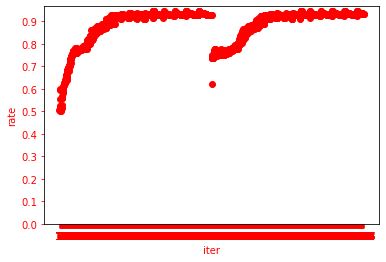

best weight [-1.2701533 -3.40404872e-17j -1.38283603-1.69054272e-17j
 -0.7182684 -2.38502484e-17j -0.54117584-8.02928236e-18j]
best rate 0.9833333333333333


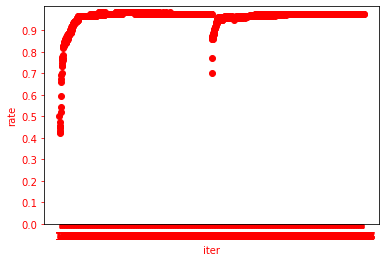

best weight [-0.72381459-8.84541424e-19j  0.18110039-3.89799762e-19j
 -1.40592436-7.92511948e-19j -0.53413583-2.71437345e-19j]
best rate 1.0


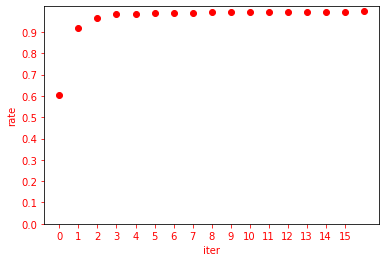

best weight [-1.09818333-3.78245779e-17j -1.21831481-2.30722419e-17j
 -1.18427521-2.83806330e-17j -1.98135598-1.76512372e-17j]
best rate 0.9388888888888889


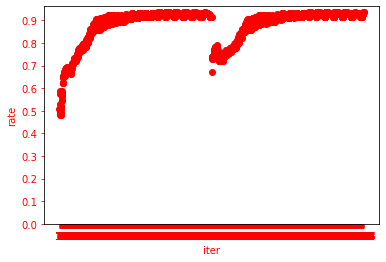

best weight [-1.28006048-4.87661262e-17j -1.37973172-2.55680642e-17j
 -0.71467014-3.62872863e-17j -0.58161432-1.26841031e-17j]
best rate 0.9833333333333333


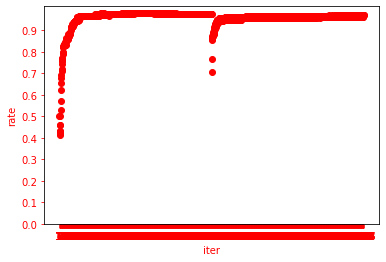

best weight [-0.723452  -7.74963526e-19j  0.1805344 -3.55822067e-19j
 -1.40728856-6.61806000e-19j -0.5342603 -2.53271394e-19j]
best rate 1.0


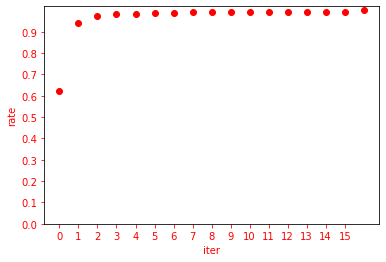

best weight [-1.0942293 -1.69149506e-17j -1.23536031-1.33944710e-17j
 -1.18757191-1.28988051e-17j -1.95613617-1.12831262e-17j]
best rate 0.9444444444444444


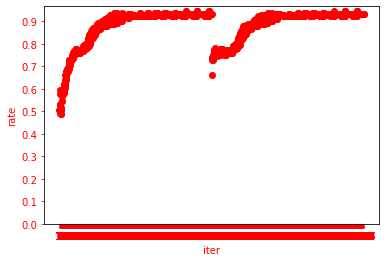

best weight [-1.2790264 +2.34737658e-18j -1.28463525-3.21067860e-18j
 -0.68239221+3.63448460e-18j -0.41603253-6.38751537e-19j]
best rate 0.9888888888888889


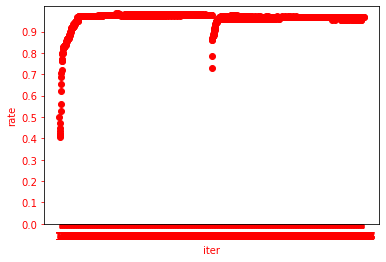

best weight [-0.72697725-6.28110508e-19j  0.17858751-2.89755732e-19j
 -1.40782233-5.43568615e-19j -0.53574176-2.01721792e-19j]
best rate 1.0


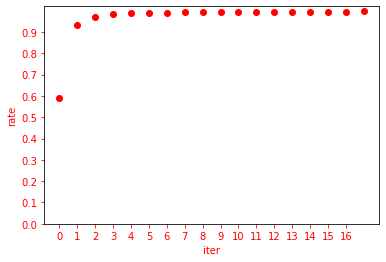

best weight [-1.11591221+1.72443521e-18j -1.21093779-7.80150559e-18j
 -1.16405956+5.51176170e-18j -1.98606612-6.17259930e-18j]
best rate 0.95


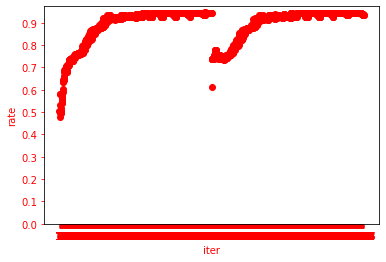

best weight [-1.30679859-8.93949517e-17j -1.3688055 -4.14997461e-17j
 -0.68331134-6.70942881e-17j -0.65607261-2.17699768e-17j]
best rate 0.9833333333333333


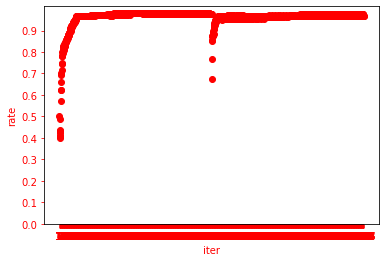

best weight [-0.72742703-1.40088709e-18j  0.17743733-6.76912160e-19j
 -1.40754066-1.01547614e-18j -0.53419741-3.34601230e-19j]
best rate 1.0


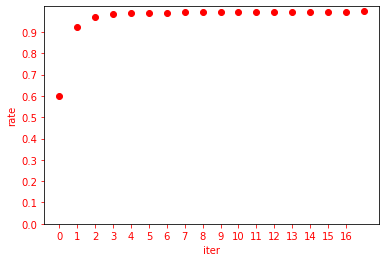

best weight [-1.06881529-2.61025762e-17j -1.22882269-1.75849174e-17j
 -1.22785838-1.96381402e-17j -1.88654178-1.45275741e-17j]
best rate 0.95


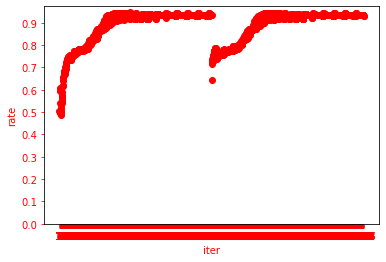

best weight [-1.28036322-3.94283784e-17j -1.37112611-2.10214089e-17j
 -0.73185563-2.90435817e-17j -0.60535044-9.89559963e-18j]
best rate 0.9833333333333333


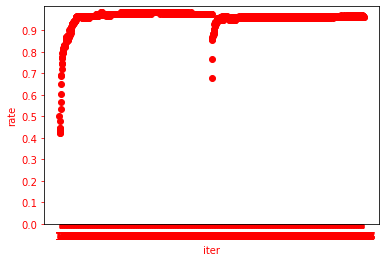

best weight [-0.72401201-8.37928372e-19j  0.18181508-3.68040280e-19j
 -1.40772376-6.66943291e-19j -0.53433546-2.33051685e-19j]
best rate 1.0


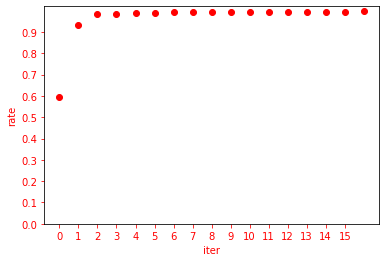

best weight [-1.11872897-4.86989364e-17j -1.20746072-2.58656404e-17j
 -1.16623947-3.66705734e-17j -1.97266124-2.01240109e-17j]
best rate 0.9666666666666667


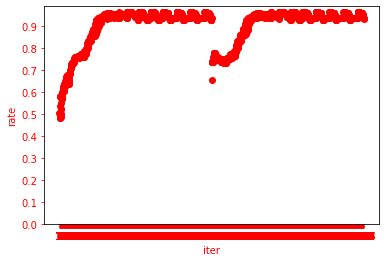

best weight [-1.2512221 -2.80694255e-17j -1.38211379-1.30896675e-17j
 -0.74137232-2.00390274e-17j -0.48909011-5.88150065e-18j]
best rate 0.9833333333333333


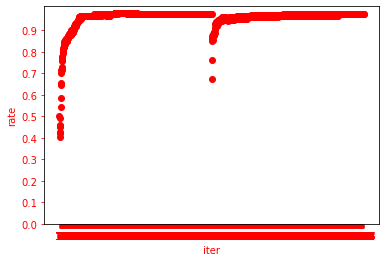

best weight [-0.72373648-5.06383925e-19j  0.18232056-2.31521753e-19j
 -1.40826149-3.89543301e-19j -0.53562112-1.22080790e-19j]
best rate 1.0


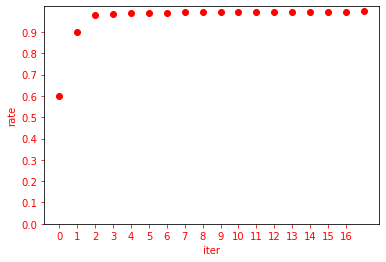

best weight [-1.09469537-6.53462942e-17j -1.20757836-3.20271681e-17j
 -1.19692672-5.18144076e-17j -1.92781431-2.67898543e-17j]
best rate 0.9444444444444444


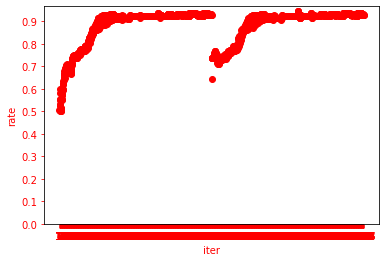

best weight [-1.25123709-1.66847939e-17j -1.38143518-9.27411243e-18j
 -0.74684977-1.13860628e-17j -0.49739811-3.76810640e-18j]
best rate 0.9888888888888889


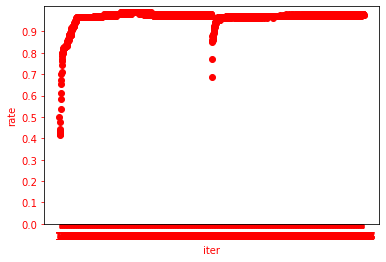

best weight [-0.72734774-3.74064685e-19j  0.17807342-1.57649629e-19j
 -1.40775736-3.32408543e-19j -0.53492787-1.25347334e-19j]
best rate 1.0


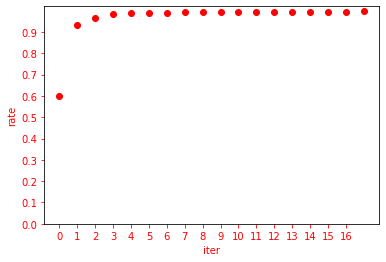

best weight [-1.04958839-2.34836436e-17j -1.23886634-1.35205174e-17j
 -1.24897742-2.08162292e-17j -1.87614344-1.48917416e-17j]
best rate 0.9388888888888889


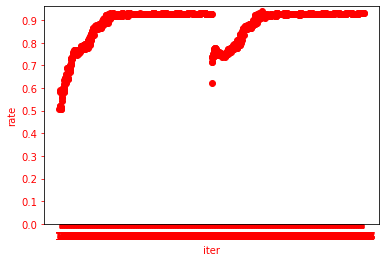

best weight [-1.27063885-4.25061558e-17j -1.3666564 -2.04852467e-17j
 -0.74599828-3.06235696e-17j -0.58126195-9.12815383e-18j]
best rate 0.9833333333333333


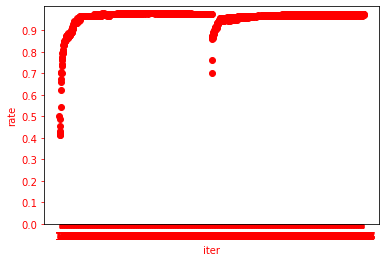

best weight [-0.72670491-8.05235595e-19j  0.17742891-3.67706142e-19j
 -1.4096152 -6.60587263e-19j -0.53570112-2.35349656e-19j]
best rate 1.0


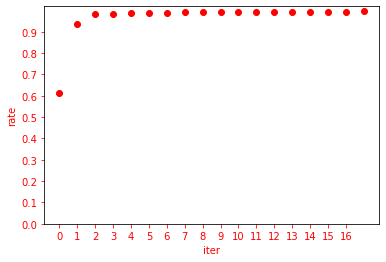

best weight [-1.12303611-2.80532212e-17j -1.21890453-1.77640967e-17j
 -1.16215352-2.14490865e-17j -1.93169908-1.78644258e-17j]
best rate 0.9611111111111111


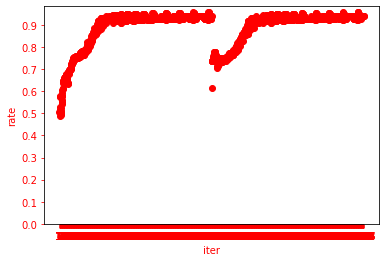

best weight [-1.25024924-2.07039223e-17j -1.38241267-1.10508194e-17j
 -0.73804321-1.50240128e-17j -0.4790204 -4.91130823e-18j]
best rate 0.9833333333333333


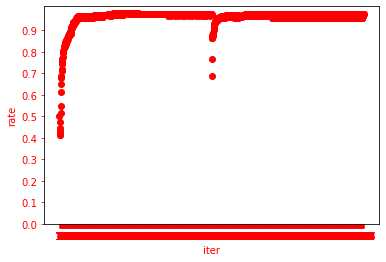

best weight [-0.72384721-5.74505638e-19j  0.18188991-2.41414185e-19j
 -1.40755691-5.00207759e-19j -0.53469311-1.66623738e-19j]
best rate 1.0


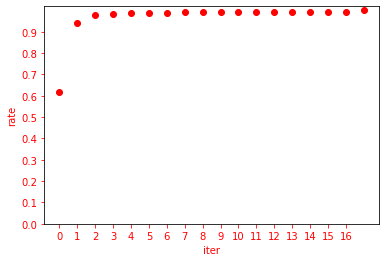

best weight [-1.14405756+5.63342546e-18j -1.20236243-2.11973212e-18j
 -1.13377793+6.37528903e-18j -1.95743307-6.57205069e-18j]
best rate 0.9611111111111111


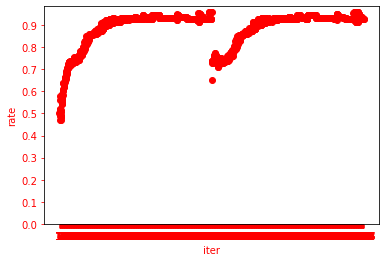

best weight [-1.30114534-9.49073099e-17j -1.36816045-4.30172836e-17j
 -0.69576489-7.10750663e-17j -0.64369207-2.18838191e-17j]
best rate 0.9833333333333333


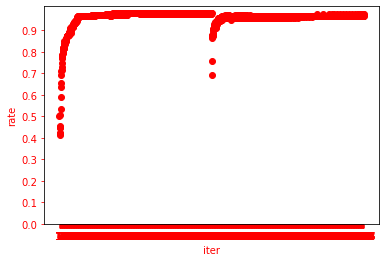

best weight [-0.72330936-9.41881328e-19j  0.18231906-4.10528522e-19j
 -1.40866222-6.95334888e-19j -0.53622969-2.40217826e-19j]
best rate 1.0


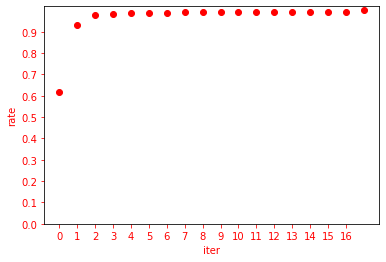

best weight [-1.13271349-5.04759472e-17j -1.20644964-2.91863622e-17j
 -1.14774189-4.04204362e-17j -1.94391646-2.45508930e-17j]
best rate 0.9388888888888889


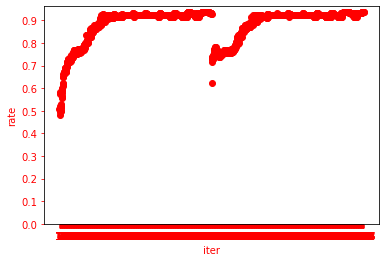

best weight [-1.2868144 -5.77813253e-17j -1.3620371 -2.71951831e-17j
 -0.72216247-4.27708884e-17j -0.61524438-1.31875714e-17j]
best rate 0.9833333333333333


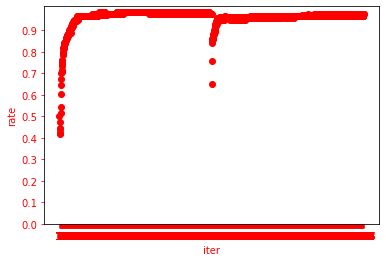

best weight [-0.72383154-7.06865489e-19j  0.18212347-3.09883878e-19j
 -1.40780036-5.86188751e-19j -0.53497831-1.99290763e-19j]
best rate 1.0


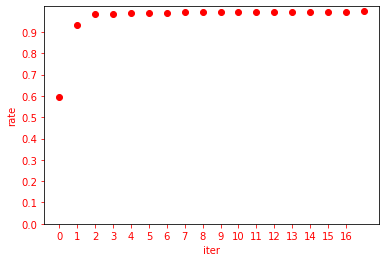

best weight [-1.1058009 -5.48243475e-17j -1.21109446-3.21097647e-17j
 -1.1756921 -4.31696415e-17j -1.98251138-2.35849739e-17j]
best rate 0.95


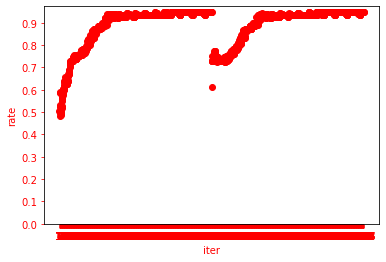

best weight [-1.25471396-4.56108959e-17j -1.32548491-2.21433188e-17j
 -0.77158627-3.40402009e-17j -0.48442562-1.00665597e-17j]
best rate 0.9888888888888889


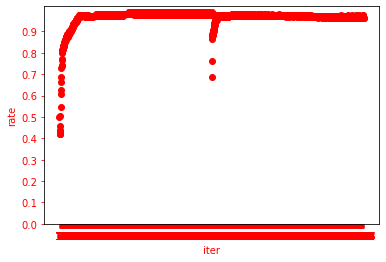

best weight [-0.71970832-2.72455032e-19j  0.18460528-1.04820474e-19j
 -1.40810707-2.95031208e-19j -0.53480902-8.94710696e-20j]
best rate 1.0


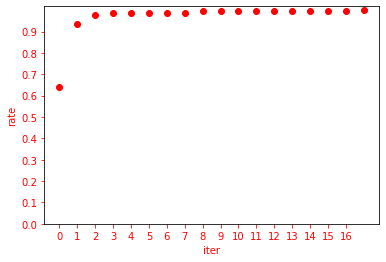

best weight [-1.09964134-1.25086517e-18j -1.23177412-5.20249693e-18j
 -1.1856077 -2.27604546e-19j -1.95937787-7.84291869e-18j]
best rate 0.9611111111111111


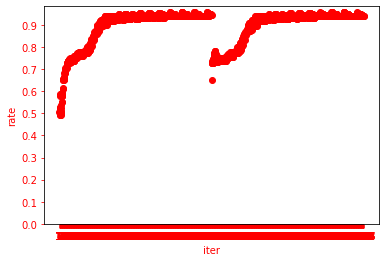

best weight [-1.26786619-4.01307794e-17j -1.36527013-2.01327760e-17j
 -0.74805463-2.94369164e-17j -0.57124571-8.94271015e-18j]
best rate 0.9833333333333333


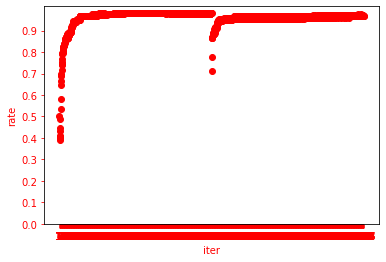

best weight [-0.72300812-4.11868038e-19j  0.1807397 -1.81409266e-19j
 -1.407182  -3.95071570e-19j -0.53540543-1.26790428e-19j]
best rate 1.0


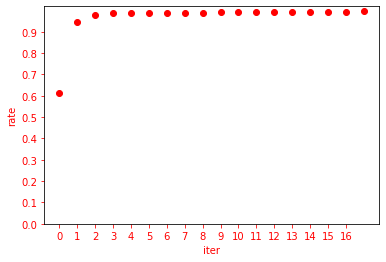

best weight [-1.09423699-1.76478738e-17j -1.23853506-1.55293035e-17j
 -1.19318619-1.47222552e-17j -1.92752238-1.18809774e-17j]
best rate 0.9611111111111111


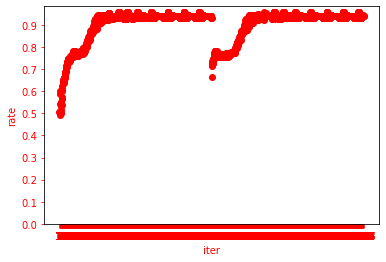

best weight [-1.25150985-2.04156297e-17j -1.38088107-1.14090301e-17j
 -0.74418077-1.43883470e-17j -0.49353763-5.01759498e-18j]
best rate 0.9833333333333333


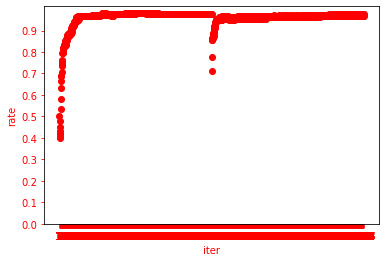

best weight [-0.72024201-5.88582112e-19j  0.18476829-2.44647954e-19j
 -1.4071026 -5.73847633e-19j -0.5341813 -2.03412948e-19j]
best rate 1.0


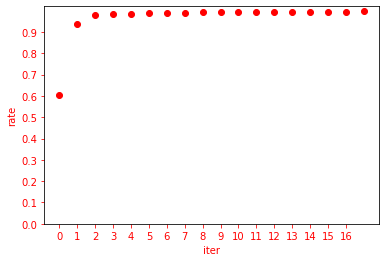

best weight [-1.06778587-8.57123551e-17j -1.16993952-4.80630041e-17j
 -1.23324313-7.12525640e-17j -1.98988461-3.34412464e-17j]
best rate 0.9722222222222222


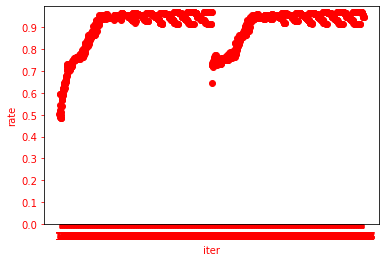

best weight [-1.27898496+2.61810213e-18j -1.320125  -3.21806106e-18j
 -0.65142361+4.40564263e-18j -0.39928886-4.69475050e-20j]
best rate 0.9944444444444445


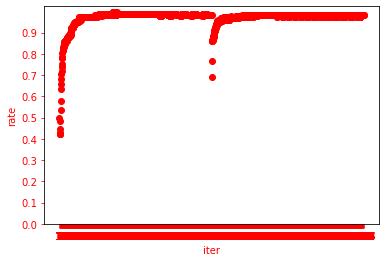

best weight [-0.72339886-1.16083845e-18j  0.18196488-5.00588650e-19j
 -1.40836875-8.71714153e-19j -0.53555416-2.98874946e-19j]
best rate 1.0


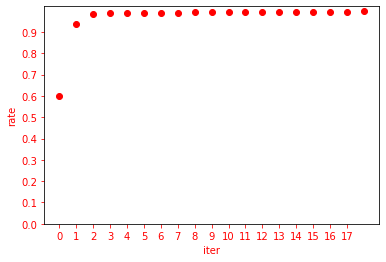

best weight [-1.13152135-2.35622140e-17j -1.21573258-1.66762349e-17j
 -1.14614446-1.86979877e-17j -1.9662727 -1.56334025e-17j]
best rate 0.95


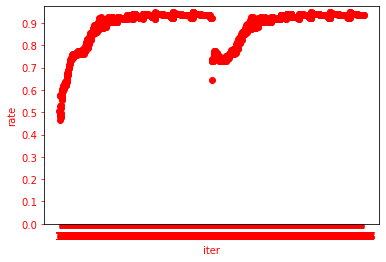

best weight [-1.29259572-8.56882843e-17j -1.36855654-3.95724651e-17j
 -0.70730005-6.45050156e-17j -0.62355121-1.97952714e-17j]
best rate 0.9833333333333333


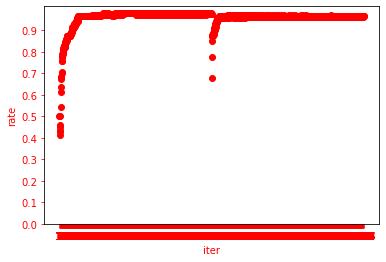

best weight [-0.72382433-9.66269896e-19j  0.18249911-4.16806001e-19j
 -1.40901733-7.45924055e-19j -0.53533564-2.45282704e-19j]
best rate 1.0


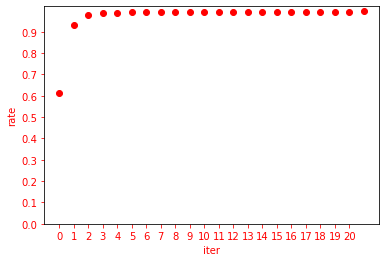

best weight [-1.12473328-5.36712899e-18j -1.22073039-6.18668017e-18j
 -1.15850569-2.47567741e-18j -1.94285876-8.20464131e-18j]
best rate 0.9611111111111111


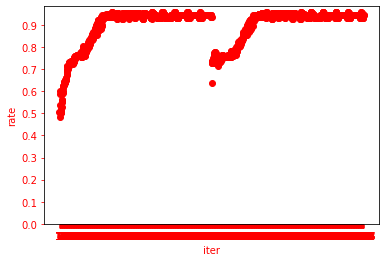

best weight [-1.25549929-1.10756601e-17j -1.33270562-4.08947829e-18j
 -0.83954839-7.89871230e-18j -0.69858995-9.37444116e-19j]
best rate 0.9888888888888889


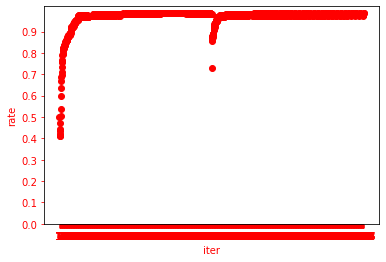

best weight [-0.72396831-9.18631599e-19j  0.1814333 -4.31508220e-19j
 -1.40811494-8.12288618e-19j -0.53417005-2.98395034e-19j]
best rate 1.0


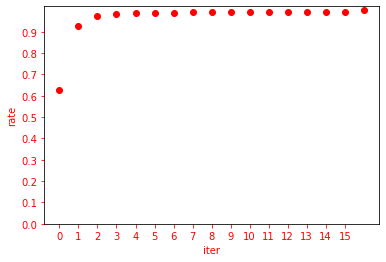

best weight [-1.0769639 +2.23267427e-17j -1.22012277+5.00345321e-18j
 -1.20971848+1.80252044e-17j -1.97535371-2.36882753e-19j]
best rate 0.95


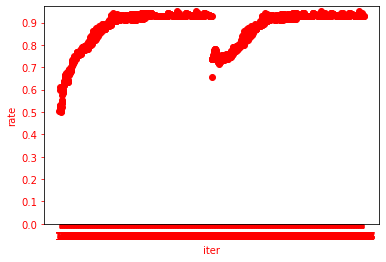

best weight [-1.26186275-3.46274175e-18j -1.38397432-6.00991902e-18j
 -0.71850082-1.07599290e-18j -0.50370835-1.71961007e-18j]
best rate 0.9833333333333333


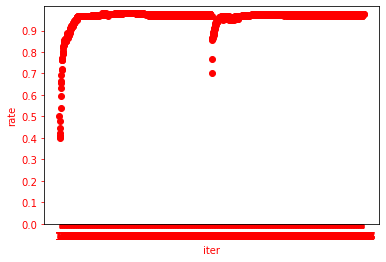

best weight [-0.6849401 -8.25550864e-19j  0.20084237-3.76093094e-19j
 -1.38611503-6.66691908e-19j -0.52643667-2.22832270e-19j]
best rate 1.0


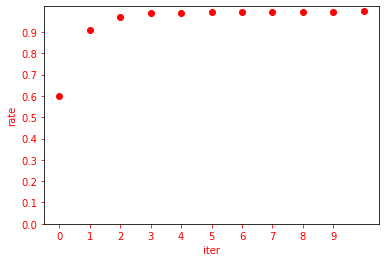

best weight [-1.10652849-1.23796953e-17j -1.24292978-1.05713561e-17j
 -1.16850617-1.08606985e-17j -1.96056392-1.41448462e-17j]
best rate 0.9444444444444444


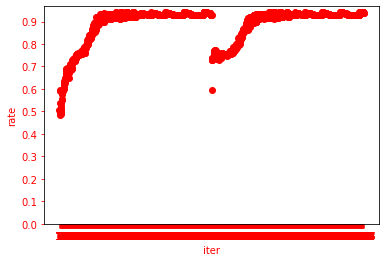

best weight [-1.19380092+3.95396670e-18j -1.33457111+2.20683787e-18j
 -0.88835877+3.42274710e-18j -0.50170125+1.45622258e-18j]
best rate 0.9888888888888889


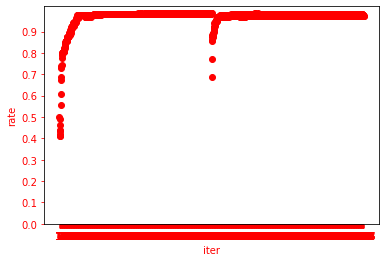

best weight [-0.68481885-1.14281324e-18j  0.20079471-5.09730889e-19j
 -1.38669358-9.27918152e-19j -0.52648003-3.06197789e-19j]
best rate 1.0


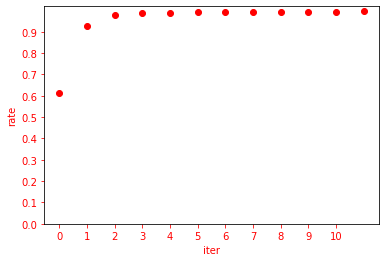

best weight [-1.08089323+5.48810623e-18j -1.22564892-2.60292720e-18j
 -1.20367894+4.42988161e-18j -1.97038204-6.88995528e-18j]
best rate 0.9444444444444444


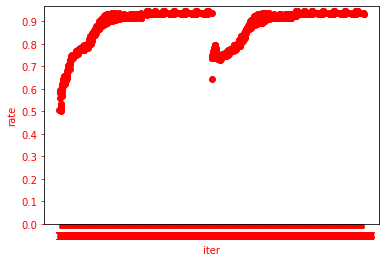

best weight [-1.27402799-4.03330038e-17j -1.37768975-2.06045715e-17j
 -0.72365259-2.99763186e-17j -0.56503466-1.02388591e-17j]
best rate 0.9833333333333333


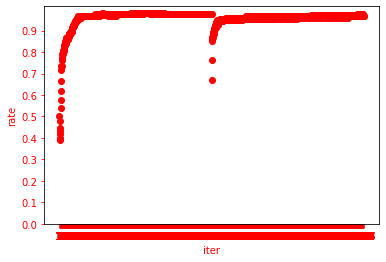

best weight [-0.72405205-1.50071016e-19j  0.18262937-5.76701010e-20j
 -1.40760184-1.44611277e-19j -0.53480067-3.11795314e-20j]
best rate 1.0


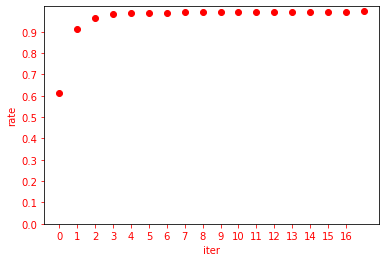

best weight [-1.10392843+3.12243806e-17j -1.23256636+1.10650238e-17j
 -1.18311648+2.46412291e-17j -1.91327546+1.99103384e-18j]
best rate 0.9611111111111111


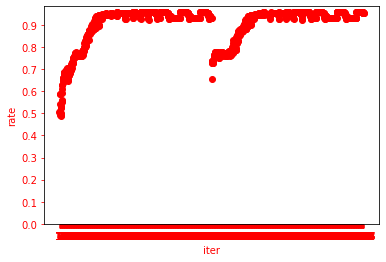

best weight [-1.30090748-8.16362792e-17j -1.37280138-3.69063654e-17j
 -0.70219458-6.15100258e-17j -0.65794651-1.88498020e-17j]
best rate 0.9833333333333333


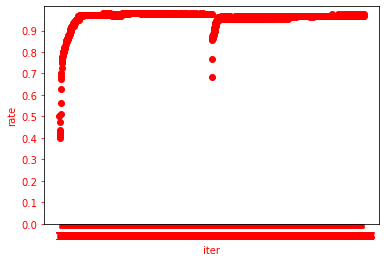

best weight [-0.6886283 -1.19230687e-18j  0.19705552-5.54892742e-19j
 -1.3863755 -9.06346954e-19j -0.52615995-3.09289131e-19j]
best rate 1.0


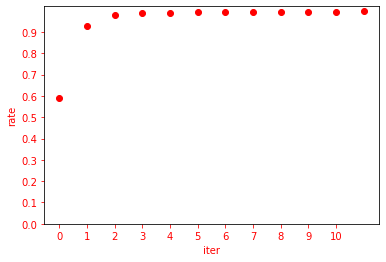

best weight [-1.11317024-3.53275784e-17j -1.2273313 -2.22059699e-17j
 -1.16880208-2.66404340e-17j -1.93019906-1.87229778e-17j]
best rate 0.9444444444444444


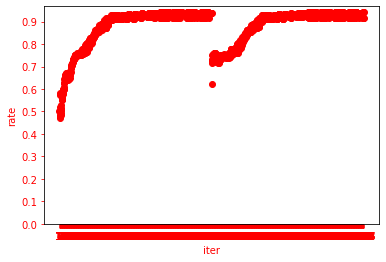

best weight [-1.25859439-3.43435517e-17j -1.38138835-1.72818736e-17j
 -0.7367887 -2.50993389e-17j -0.5158124 -7.84142232e-18j]
best rate 0.9833333333333333


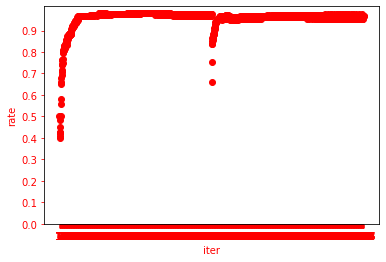

best weight [-0.72046666-1.07889153e-18j  0.18511481-4.91309863e-19j
 -1.40651346-8.18086344e-19j -0.53413809-2.73249297e-19j]
best rate 1.0


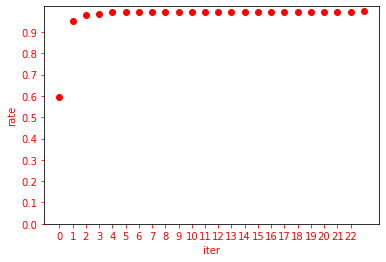

best weight [-1.09875346-2.21179786e-17j -1.22374973-1.55235074e-17j
 -1.18411811-1.81388971e-17j -1.96329582-1.40496598e-17j]
best rate 0.9388888888888889


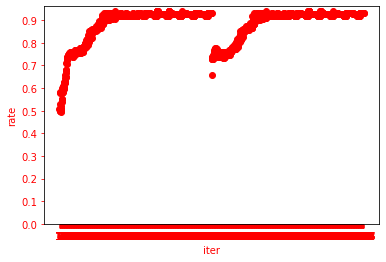

best weight [-1.30429905-9.29608723e-17j -1.3708952 -4.04263450e-17j
 -0.70073521-7.04673854e-17j -0.67065746-2.09696097e-17j]
best rate 0.9833333333333333


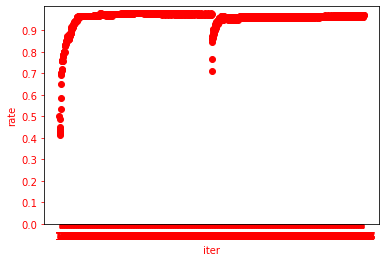

CPU times: user 5h 31min 3s, sys: 7min 44s, total: 5h 38min 47s
Wall time: 5h 42min


In [9]:
%%time
scores = []
f1scores = []
for i_random_state in range(30):
    score, f1score = executeIris(randomState = i_random_state, 
                classifierFunction=create_and_execute_classifier_ORIGINAL, 
                paramsClassifier=[1,1,1,0], 
                MAX_ITER=2000)
    scores.append(score)
    f1scores.append(f1score)

In [10]:
scores

[0.9333333333333333,
 1.0,
 0.9333333333333333,
 0.9333333333333333,
 0.9333333333333333,
 1.0,
 0.9333333333333333,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9333333333333333,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9333333333333333,
 1.0,
 1.0,
 0.9333333333333333,
 0.9333333333333333,
 0.8666666666666667,
 1.0,
 0.9333333333333333,
 1.0,
 1.0,
 1.0,
 1.0]

In [11]:
np.mean(scores)

0.9733333333333334